# PROJECT REPORT GROUP 17

## "Gender Differences in Cholesterol Levels among Individuals Diagnosed with Heart Disease: A Statistical Analysis of the Cleveland Heart Disease Dataset"

### Introduction

Cholesterol is a critical biomarker that plays a significant role in cardiovascular health. Heart disease, also known as cardiovascular disease, is a leading cause of morbidity and mortality globally. It is well-established that elevated cholesterol levels are associated with an increased risk of heart disease. Therefore, understanding the cholesterol levels in individuals diagnosed with heart disease can provide valuable insights into potential risk factors and gender-specific patterns that may contribute to the development of this condition. 


Our project aims to answer the question, "Are there significant mean cholesterol level (mg/dl) differences bewteen men and women diagnosed with heart disease?" In the analysis, we will consider cholesterol level as our random variable of interest, for men and women, using mean as the location parameter. Additionally we will investigate the standard deviation (scale parameter) to understand the variability/ spread within each group.


The dataset we use in our analysis is the "Cleveland Heart Disease Dataset", obtained from a reputable source (URL provided). It contains various attributes related to heart disease, such as age, sex, chest pain type, blood pressure, cholesterol level, fasting blood sugar, and more. We want to focus on the variables "sex" and "cholesterol_level" for our investigation, and thus will drop the less relevant variables to streamline our analysis.

A brief outline of our project is as follows: we will clean and tidy the dataset, selecting relevant variables (i.e. 'sex', 'cholesterol levels'). Our null hypothesis will state that mean cholesterol levels across males and females are equal; our alternate hypothesis will state that there is a difference in the mean cholesterol levels. We will conduct initial exploration using box plots (Figure 1), to overview the distribution and potential differences in mean cholesterol levels. The main analysis will be dont using bootstrapping methods (resampling with replacement). The resulting bootstrap distribution (Table 2) will help us approximate the sample mean. 

### Methods and Results

We start by loading in the necesary libraries and dataset.

In [9]:
#Load this before continuing
library(tidyverse)
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(broom)

ERROR: Error in library(infer): there is no package called ‘infer’


In [10]:
#Reading data into R
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland_heart <- read_csv(url)
head(cleveland_heart)

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


63.0,1.0...2,1.0...3,145.0,233.0,1.0...6,2.0,150.0,0.0...9,2.3,3.0,0.0...12,6.0,0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


In [11]:
#Change column names to given varaibles from dataset
colnames(cleveland_heart) <- c("age", "sex", "chest_pain", "resting_blood_pressure", "cholesterol_level", "fasting_blood_sugar", "resting_ecg_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "oldpeak", "slope", "major_vessels_colored", "thal", "diagnosis")
head(cleveland_heart)

age,sex,chest_pain,resting_blood_pressure,cholesterol_level,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,major_vessels_colored,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


We select 'sex' and 'cholesterol_level' from our dataset, ensuring that we filter out missing values and irrelevant variables.

In [12]:
# Tidy data to relevant variables
cleveland_heart$sex <- as.character(cleveland_heart$sex)
cleveland_heart$sex[cleveland_heart$sex == "1"] <- "M"
cleveland_heart$sex[cleveland_heart$sex == "0"] <- "F"

cleveland_heart <- cleveland_heart %>%
    filter(!is.na(cholesterol_level)) |>
    filter(!is.na(sex)) |>
    filter(!diagnosis == 0) %>%
    select(sex, cholesterol_level)

head(cleveland_heart)

sex,cholesterol_level
<chr>,<dbl>
M,286
M,229
F,268
M,254
M,203
M,256


*Table 1*

We first perform explanatory data analysis, taking a look at boxplots between the two sex.

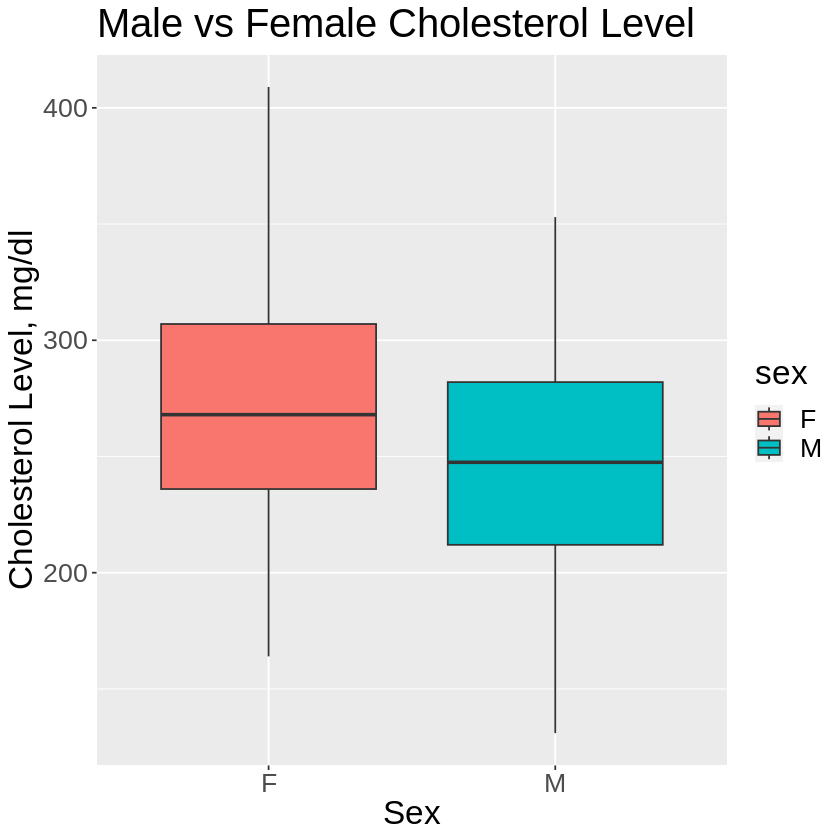

In [13]:
# boxplot of raw data
box <- cleveland_heart %>%
    ggplot() +
        geom_boxplot(aes(x = sex, y = cholesterol_level, fill = sex)) +
        ggtitle("Male vs Female Cholesterol Level") +
        xlab("Sex") +
        ylab("Cholesterol Level, mg/dl") +
        theme(text = element_text(size = 20))

box

*Figure 1*

<b> Bootstrap Distribution </b> <br>
We will start by using bootstrapping methods to carry out our analysis. We resample from our sample multiple times to generate a bootstrap distribution, which will allow us to estimate for the mean, standard errors, and confidence intervals. 

In [34]:
# bootstrap tidied sample
btsp <- cleveland_heart %>%
    specify(formula = cholesterol_level ~ sex) %>%
    generate(reps = 2000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("F", "M"))

head(btsp)

replicate,stat
<int>,<dbl>
1,27.60295
2,18.54201
3,25.58718
4,8.13792
5,22.14068
6,30.28403


*Table 2*

We will now calculate the 95% confidence interval, and plot the bootstrap distribution.

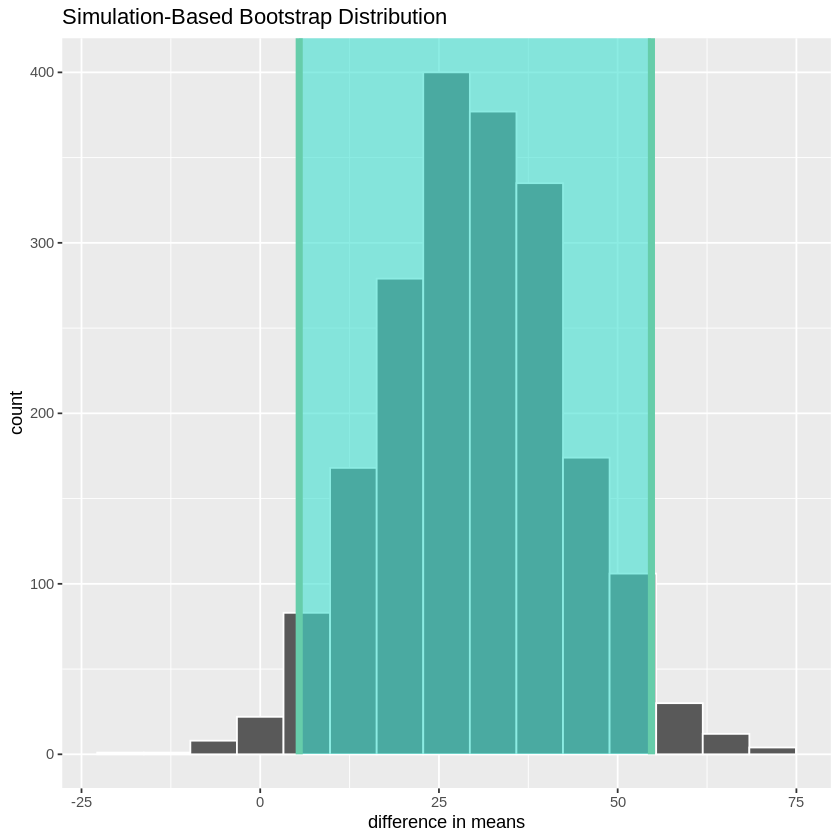

In [57]:
btsp_ci <- btsp %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

# plot bootstrap distribution
btsp_dist <-
    visualize(btsp) + 
    shade_ci(endpoints = btsp_ci) + 
    xlab("difference in means")

btsp_dist

*Figure 2*

<b> Null Distribution </b> <br>

Restating our hypothesis below: 

$H_0$: Mean cholesterol levels are equal between male and female. 

$H_1$: Mean cholesterol levels for males are different from the mean cholesterol levels for females.

We will now generate samples from the null distribution and carry out the hypothesis test. Our significance level for this test will be set to 0.05.

In [49]:
# using our preprocessed data to get the Observed test stat (difference in means)
obs_diff_in_means <- 
    cleveland_heart  %>% 
    specify(formula = cholesterol_level ~ sex) %>%
    calculate(stat = "diff in means", order = c("F", "M"))

obs_diff_in_means

stat
<dbl>
30.0986


We calculate our test statistic (difference in means) to be around 30. We will now plot the null distribution, and calculate the p-value.

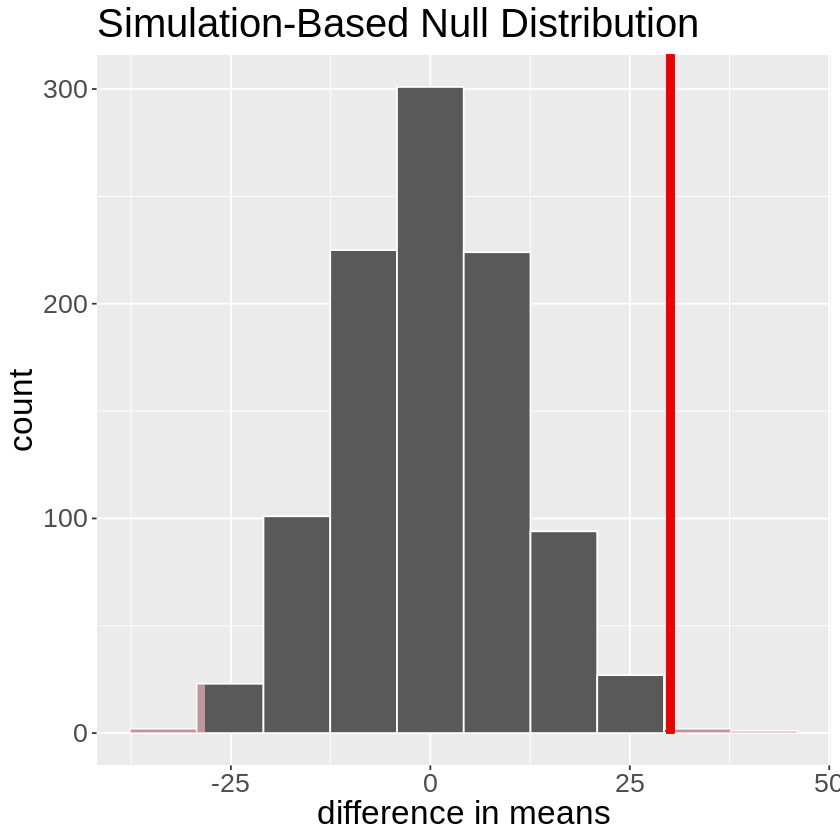

In [53]:
# Generate 1000 samples from Null distrib.
null_diff_in_means <- 
    cleveland_heart %>% 
    specify(formula = cholesterol_level ~ sex) %>%
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute")  %>%
    calculate(stat = "diff in means", order = c("F", "M"))

#Plot result of hypothesis test
diff_in_medians_plot <-
    visualize(null_diff_in_means, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "both") +
    xlab("difference in means") + theme(text = element_text(size = 20))

diff_in_medians_plot

In [55]:
# Calculating p value 
p_value <-
    null_diff_in_means %>% 
    get_p_value(obs_stat =  obs_diff_in_means, direction = "both")

p_value

p_value
<dbl>
0.004


Since we do not know the population standard deviation, we will not use the Central Limit Theorem in our analysis. However we can use the two-sample T test to find the difference in means.

Again, our hypothesese are as follows:

$H_0$: Mean cholesterol levels are equal between male and female. 

$H_1$: Mean cholesterol levels for males are different from the mean cholesterol levels for females.

In [14]:
# # Calculate means and variance of each sex
summary_female <- cleveland_heart %>%
    filter(sex == "F") %>%
    summarise(mean = mean(cholesterol_level),
              var = var(cholesterol_level),
              n = n())
summary_male <- cleveland_heart %>%
    filter(sex == "M") %>%
    summarise(mean = mean(cholesterol_level), 
              var = var(cholesterol_level),
              n = n())

# # Calculate test stat 
test_stat <- (summary_female$mean - summary_male$mean) / 
                sqrt((summary_female$var/summary_female$n) + (summary_male$var / summary_male$n))

print(paste("Test Statistic:", test_stat))

# Get p value               
p_value <- pt(test_stat, df = summary_female$n - 1, lower.tail = FALSE)

print(paste("P-value:", p_value))

# Perform t test 
test_result <- t.test(cleveland_heart$cholesterol_level[cleveland_heart$sex == "F"], 
                      cleveland_heart$cholesterol_level[cleveland_heart$sex == "M"], 
                      "two.sided") %>%
    tidy()
test_result

[1] "Test Statistic: 2.36800817102482"
[1] "P-value: 0.0131414840057474"


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
30.0986,276.16,246.0614,2.368008,0.0244486,30.34038,4.152474,56.04472,Welch Two Sample t-test,two.sided


### Discussion *** TO DO ***

From project criteria: 

"In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.
Summarize what you found, and the implications/impact of your findings.
If relevant, discuss whether your results were what you expected to find.
Discuss future questions/research this study could lead to."


SERRA - important stats below, can reword & add to this:
- Our p value was 0.004. alpha set to 0.05. 
- p <  a. reject null. means there is significant diff between levels in men and women.
- conf interval was 1-alpha = 0.95


MY ANSWER(PLEASE EDIT AND MAKE THE FINAL VERSION)


Discussion: Implications of Gender-Specific Differences in Mean Cholesterol Levels Among Heart Disease Patients

The investigation into the mean cholesterol levels of men and women diagnosed with heart disease has provided valuable insights into potential risk factors and distinctive patterns associated with cardiovascular health. The project's outcomes shed light on the importance of considering gender-specific factors when analyzing heart disease and its associated biomarkers.


Significant Difference in Cholesterol Levels:
The central finding of this analysis is the statistically significant difference in mean cholesterol levels between men and women diagnosed with heart disease. The calculated p-value of 0.004 is notably lower than our predetermined significance level (alpha) of 0.05. Consequently, we reject the null hypothesis, which stated that mean cholesterol levels across genders are equal. This rejection implies that the variation in cholesterol levels observed between men and women is not due to random chance but holds meaningful implications.


Clinical and Preventive Implications:
The observed difference in cholesterol levels has significant implications for clinical practice and preventive strategies. Healthcare providers should be cognizant of the gender-specific variations in cholesterol levels when diagnosing and treating heart disease. Tailoring treatment plans to these gender-based differences could potentially enhance the efficacy of interventions and ultimately improve patient outcomes.


Insight into Gender-Specific Cardiovascular Health:
Our findings contribute to a growing body of knowledge emphasizing the importance of gender-specific approaches to cardiovascular health. It is well-documented that men and women can experience heart disease differently due to variations in risk factors, symptoms, and responses to treatments. By identifying gender-specific differences in cholesterol levels, we contribute to the nuanced understanding of heart disease progression in diverse patient populations.


Future Research and Further Questions:
This analysis prompts several avenues for future research and exploration. Investigating the underlying factors driving the observed difference in cholesterol levels could provide deeper insights into gender-specific cardiovascular physiology. Additionally, examining how these differences in cholesterol levels correlate with other heart disease risk factors, such as age, genetics, and lifestyle, could lead to a more comprehensive understanding of heart disease etiology.


Limitations and Considerations:
While our analysis underscores the significance of gender-specific differences, it is important to acknowledge the limitations of the study. The dataset used in this analysis may not capture the entire spectrum of heart disease patients, potentially influencing the generalizability of our findings. Furthermore, other confounding variables that were not included in our analysis might contribute to the observed differences.


Conclusion:
In conclusion, this project's exploration of mean cholesterol levels in men and women diagnosed with heart disease highlights the importance of gender-specific considerations in cardiovascular health research. The statistically significant difference in cholesterol levels emphasizes the need for tailored approaches to diagnosis, treatment, and prevention. By uncovering these gender-specific patterns, we take a step forward in advancing our understanding of heart disease and enhancing patient care.

### References

Janosi, Andras, et al. “Heart Disease.” UCI Machine Learning Repository, 1988, archive.ics.uci.edu/ml/datasets/Heart+Disease. https://doi.org/10.24432/C52P4X.

Efron, Bradley, and Robert Tibshirani. “Bootstrap Resampling and Confidence Intervals.” An Introduction to the Bootstrap, Chapman and Hall, New York, 1993. 